In [2]:
# basin-sizes-to-control-kernel-sizes.ipynb
#
# Bryan Daniels
# 2024/1/4
#
# Can we use basin sizes to better predict control kernel sizes?
#
# An outgrowth from cell-collective-basin-entropy.ipynb

In [156]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from toolbox.simplePickle import load,save

In [2]:
# useful code for dealing with cell collective networks from from code/cellCollective.py
def directory_name(n_name):
    """
    Returns the name of the Cell Collective directory given
    the "nice" name with spaces
    """
    return n_name.replace(' ','_').replace('.','')
    
def nice_name(dir_name):
    """
    Returns the "nice" name of the Cell Collective network
    given the directory name
    """
    nice = dir_name.replace('_',' ')
    if nice == 'Iron Acquisition And Oxidative Stress Response In Aspergillus Fumigatus':
        nice = nice+'.'
    return nice

# Load existing data

### Load Cell Collective control kernel data from 2021 paper

In [3]:
control_kernel_data_file = '/Users/bdaniel6/ASUDropbox/Research/grn-survey/Writeups/control-kernel-2020/'\
    'Nature Comm final revision Aug 2021/zenodo Aug 2021/20200820_control_kernel_supplemental_info.csv'
ck_df = pd.read_csv(control_kernel_data_file).set_index('name')

# include expected average ck size and difference from expected
ck_df['expected mean control kernel size'] = np.log2(ck_df['number of attractors'])
ck_df['difference from expected mean control kernel size'] = \
    ck_df['mean control kernel size'] - ck_df['expected mean control kernel size']

print("We have exact control kernel data for {} networks.".format((1-ck_df['uses sampling method']).sum()))

We have exact control kernel data for 44 networks.


### Load basin data from newer Cell Collective runs

In [4]:
datadir = '../code/'

In [5]:
# concatenate all csv file data
df_list = []
for filename in glob.glob(datadir+'basin_entropy_data*.csv'):
    df_single = pd.read_csv(filename)
    df_list.append(df_single)
df = pd.concat(df_list).set_index('name')
#df = df.apply(pd.to_numeric,errors='coerce')
# make everything numeric except for "elapsed_time"
numeric_cols = df.columns[df.columns != 'elapsed_time']
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric,errors='coerce')
df.head()

,network_size,num_states,num_samples,num_attractors,basin_entropy_NSB,std_basin_entropy_NSB,elapsed_time
name,,,,,,,
Budding_Yeast_Cell_Cycle,20,1048576,10000,33,4.692749,0.008449,0:00:18.083787
Mammalian_Cell_Cycle,20,1048576,10000,3,1.014787,0.003261,0:00:02.020575
HCC1954_Breast_Cell_Line_Long-term_ErbB_Network,25,33554432,10000,9452,8.269992,0.021576,0:11:16.461616
Cortical_Area_Development,5,32,10000,2,0.568464,0.155180,0:00:00.808031
B_Cell_Differentiation,22,4194304,10000,61,5.440223,0.008863,0:00:04.590949


In [6]:
print("We have sampled basin data for {} networks.".format(len(df)))

We have sampled basin data for 34 networks.


In [7]:
# gather all detailed basin data into a dictionary
basinDataDict = {}
for name in df.index:
    data = load('{}basin_entropy_data_{}.pkl'.format(datadir,name))
    basinDataDict[name] = data

In [8]:
# find missing networks 
done_names = [ nice_name(name) for name in df.index ]
not_done_names = set(ck_df.index) - set(done_names)

print("There are {} networks with CK data, {} with basin entropy data, and {} missing.".format(
    len(ck_df),len(done_names),len(not_done_names)))

There are 49 networks with CK data, 34 with basin entropy data, and 15 missing.


In [9]:
not_done_names

{'Arabidopsis Thaliana Cell Cycle',
 'Bordetella Bronchiseptica',
 'Budding Yeast Cell Cycle 2009',
 'Cholesterol Regulatory Pathway',
 'FA BRCA Pathway',
 'Fanconi Anemia And Checkpoint Recovery',
 'Guard Cell Abscisic Acid Signaling',
 'Lymphoid And Myeloid Cell Specification And Transdifferentiation',
 'Mammalian Cell Cycle 2006',
 'Pc12 Cell Differentiation',
 'Septation Initiation Network',
 'T-Cell Signaling 2006',
 'Treatment Of Castration-Resistant Prostate Cancer',
 'Tumour Cell Invasion And Migration',
 'Yeast Apoptosis'}

### Load basin data for random networks (as of 2024/1/11, the basin data for random networks does not match up correctly with the CK data for random networks)

In [10]:
from load_control_kernel_data import loadDataExact,loadDataBasins

In [11]:
dataDir = '/Users/bdaniel6/ASUDropbox/Shared/GRNs/DATA/'
dataDirRBN = dataDir+'20201215-control-kernels-rbn/'
dataDirRandom = dataDir+'20201211-control-kernels-random/'
# as of 2024/1/11, the basin data for random networks does not match up correctly with the 
# CK data for random networks, so we won't load the old basin data for random networks
#dataDirRBNbasins = dataDir+'20210401-basins-rbn/'
dataDictExactRBN,dfExactRBN = loadDataExact(dataDirRBN)
dataDictExactRandom,dfExactRandom = loadDataExact(dataDirRandom)
#dataDictRandomBasins,dfRandomBasins = loadDataBasins(dataDirRBNbasins)

/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [12]:
# combine the two random ensembles
dfExactRandomAll = pd.concat([dfExactRBN,dfExactRandom])

### Also manually include basin data and control data for "counterexample" networks

In [13]:
# manually inputting data from the "seven_weirdos" file (actually 9 networks)
names = ['Net 16','Net 20','Net 30','Net 35','Net 40','Net 45','Net 46a','Net 46b','Net 70']
net_sizes = [10,10,15,15,15,15,15,15,20]
basin_sizes = [ [600,422,1,1],
                [1023,1],
                [16384,8192,4088,4088,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
                [32767,1],
                [32766,1,1],
                [32767,1],
                [23054,5630,4083,1],
                [32766,1,1],
                [358134,277682,243000,169758,1,1]
              ]
ck_sizes = [ [1,2,8,10],
             [1,10],
             [1,2,4,4,14,14,15,14,14,14,14,14,14,15,15,15,15,15,15,15],
             [1,15],
             [1,15,15],
             [1,15],
             [1,2,4,15],
             [np.nan,5,5],
             [2,3,2,2,20,20]
           ]
# checks
for lst in [names,basin_sizes,ck_sizes,net_sizes]:
    assert(len(lst)==9)
for basins,cks in zip(basin_sizes,ck_sizes):
    assert(len(basins)==len(cks))

In [14]:
[np.nanmean(ck_size) for ck_size in ck_sizes]

[5.25, 5.5, 12.15, 8.0, 10.333333333333334, 8.0, 5.5, 5.0, 8.166666666666666]

In [15]:
for i,name in enumerate(names):
    # store basin data in basinDataDict
    basinDataDict[name] = {'name':name,
                           'network_size':net_sizes[i],
                           'sampled_basin_freqs':basin_sizes[i],
                          }
    
    # store mean control kernel data in ck_df
    ck_df.loc[name,'size'] = net_sizes[i]
    ck_df.loc[name,'mean control kernel size'] = np.nanmean(ck_sizes[i])
    ck_df.loc[name,'number of attractors'] = len(ck_sizes[i])
    ck_df.loc[name,'number of attractors with control kernel'] = np.sum(~np.isnan(ck_sizes[i]))
    ck_df.loc[name,'number of uncontrollable attractors'] = np.sum(np.isnan(ck_sizes[i]))
    ck_df.loc[name,'expected mean control kernel size'] = np.log2(ck_df.loc[name,'number of attractors'])
    ck_df.loc[name,'difference from expected mean control kernel size'] = \
        ck_df.loc[name,'mean control kernel size'] - ck_df.loc[name,'expected mean control kernel size']

### 2024/1/12 recompute basin data for random networks (or load from file)

(note that this code explicitly reconstructs the random networks instead of relying on random seeds to produce consistent results)

In [166]:
recompute = False # takes about 25 minutes to compuate everything here

In [167]:
if recompute: 
    # compute for random weight-threshold networks
    basinSizesExactRandom = {}
    for name in tqdm.tqdm(dataDictExactRandom):
        CKdata = dataDictExactRandom[name]
        weights = CKdata['net_weights']
        thresholds = CKdata['net_thresholds']
        net = WTNetwork(weights,thresholds=thresholds)
        basinSizesExactRandom[name] = net.basin_sizes
    save(basinSizesExactRandom,'241112_basinSizesExactRandom.pkl')
else:
    basinSizesExactRandom = load('241112_basinSizesExactRandom.pkl')

In [168]:
if recompute:
    # compuate for "RBN" random networks
    basinSizesExactRBN = {}
    for name in tqdm.tqdm(dataDictExactRBN):
        CKdata = dataDictExactRBN[name]
        table = CKdata['net_table']
        net = LogicNetwork(table)
        basinSizesExactRBN[name] = net.basin_sizes
    save(basinSizesExactRBN,'241112_basinSizesExactRBN.pkl')
else:
    basinSizesExactRBN = load('241112_basinSizesExactRBN.pkl')

# Define and test functions to predict control kernel sizes from basin sizes

In [16]:
def samples_to_freqs(samples,laplace=True):
    total_samples = np.sum(samples)
    if laplace:
        freqs = (np.array(samples) + 1)/(total_samples + len(samples))
    else:
        freqs = np.array(samples)/total_samples
    return freqs

In [207]:
# define functions for estimating average control kernel size

# just log2(r)
def predict_ck_simple(basin_sizes,n):
    num_attractors = len(basin_sizes)
    return np.log2(num_attractors)

# rough loglinear fit taken from cell-collective-basin-entropy.ipynb
def predict_ck_loglinear(basin_sizes,n,laplace=True):
    num_attractors = len(basin_sizes)
    freqs = samples_to_freqs(basin_sizes,laplace=laplace)
        
    relative_corrections = 0.3-0.1*np.log(freqs)
    predicted_cks = np.log2(num_attractors)*relative_corrections

    return np.mean(predicted_cks)

# n when basin size is <=1, log2(r) otherwise
def predict_ck_separate_unstable(basin_sizes,n):
    num_attractors = len(basin_sizes)
    num_unstable = np.sum(np.array(basin_sizes)<=1)
    return np.log2(num_attractors) + (n-np.log2(num_attractors))*num_unstable/num_attractors

# enrico's skew/3 correction
def predict_ck_skew(basin_sizes,n,laplace=True):
    num_attractors = len(basin_sizes)
    freqs = samples_to_freqs(basin_sizes,laplace=laplace)
    return np.log2(num_attractors) + scipy.stats.skew(freqs)/3.

def basin_skew(basin_sizes,n,laplace=True):
    num_attractors = len(basin_sizes)
    freqs = samples_to_freqs(basin_sizes,laplace=laplace)
    return scipy.stats.skew(freqs)

def proportion_of_isolated_fixed_points(basin_sizes,n):
    return np.mean([ size == 1 for size in basin_sizes ])

In [209]:
# calculate the predicted mean control kernel sizes and store them in ck_df
functions_to_test = [predict_ck_simple,
                     predict_ck_loglinear,
                     predict_ck_separate_unstable,
                     predict_ck_skew,
                     basin_skew,
                     proportion_of_isolated_fixed_points]
for ck_func in functions_to_test:
    ck_df[ck_func.__name__] = np.nan*np.zeros(len(ck_df))
    for name in basinDataDict.keys():
        basin_samples = basinDataDict[name]['sampled_basin_freqs']
        n = basinDataDict[name]['network_size']
        predicted_CK = ck_func(basin_samples,n)
        ck_df.loc[nice_name(name),ck_func.__name__] = predicted_CK
        
    # do separately for random networks
    # using new data from 2024/1/12
    for name in basinSizesExactRandom.keys():
        basin_sizes = basinSizesExactRandom[name]
        n = dataDictExactRandom[name]['size']
        predicted_CK = ck_func(basin_sizes,n)
        dfExactRandomAll.loc[name,ck_func.__name__] = predicted_CK
    for name in basinSizesExactRBN.keys():
        basin_sizes = basinSizesExactRBN[name]
        n = dataDictExactRBN[name]['size']
        predicted_CK = ck_func(basin_sizes,n)
        dfExactRandomAll.loc[name,ck_func.__name__] = predicted_CK

/var/folders/2y/r9yfmnys37xd00fknrv2tgym0000gn/T/ipykernel_14008/1423690353.py:28: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return np.log2(num_attractors) + scipy.stats.skew(freqs)/3.
/var/folders/2y/r9yfmnys37xd00fknrv2tgym0000gn/T/ipykernel_14008/1423690353.py:33: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return scipy.stats.skew(freqs)


In [45]:
ck_df.columns

Index(['size', 'number of attractors',
       'number of attractors with control kernel', 'mean control kernel size',
       'std control kernel size', 'number of input nodes',
       'uses sampling method', 'number of uncontrollable attractors',
       'fraction of uncontrollable attractors', 'number of cycles',
       'number of modules', 'paper citation', 'url to paper',
       'url to cell collective model', 'expected mean control kernel size',
       'difference from expected mean control kernel size',
       'predict_ck_simple', 'predict_ck_loglinear',
       'predict_ck_separate_unstable', 'predict_ck_skew', 'basin_skew'],
      dtype='object')

In [53]:
# filter out cases without exact basins
ck_df_filtered = ck_df[ck_df['size']<14]

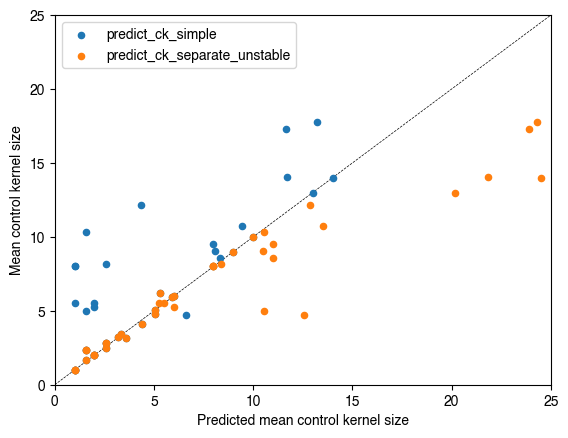

In [162]:
# plot predicted versus actual mean control kernel size

for ck_func in [predict_ck_simple,predict_ck_separate_unstable]: #functions_to_test[:-1]:
    plt.scatter(ck_df[ck_func.__name__],
                ck_df['mean control kernel size'],
                label=ck_func.__name__,
                s=20)

plt.xlabel('Predicted mean control kernel size')
plt.ylabel('Mean control kernel size')
minsize,maxsize = 0,25
plt.plot([minsize,maxsize],[minsize,maxsize],'k--',lw=0.5,zorder=-10)
plt.axis(xmin=minsize,xmax=maxsize,ymin=minsize,ymax=maxsize)
plt.legend()

# 2024/1/9 single point for selected network
#plt.plot([15.66,],[17.32,],'^')

In [26]:
# make separate dataframe for just the 9 "weirdo" networks
ck_df_weirdo = ck_df.iloc[-9:]

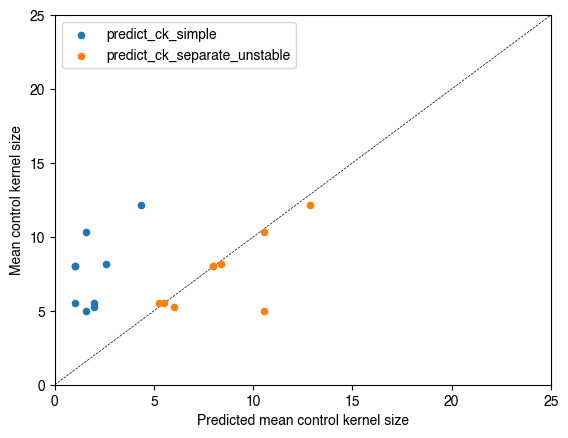

In [28]:
# plot predicted versus actual mean control kernel size for just "weirdo" networks

for ck_func in [predict_ck_simple,predict_ck_separate_unstable]: #functions_to_test[:-1]:
    plt.scatter(ck_df_weirdo[ck_func.__name__],
                ck_df_weirdo['mean control kernel size'],
                label=ck_func.__name__,
                s=20)

plt.xlabel('Predicted mean control kernel size')
plt.ylabel('Mean control kernel size')
minsize,maxsize = 0,25
plt.plot([minsize,maxsize],[minsize,maxsize],'k--',lw=0.5,zorder=-10)
plt.axis(xmin=minsize,xmax=maxsize,ymin=minsize,ymax=maxsize)
plt.legend()

# 2024/1/9 single point for selected network
#plt.plot([15.66,],[17.32,],'^')

In [31]:
# find outlier 
diff = ck_df_weirdo.predict_ck_separate_unstable - ck_df_weirdo['mean control kernel size']
ck_df_weirdo[diff > 5]
# this is the same outlier as below: random_49_tp0.5_seed6027

,size,number of attractors,number of attractors with control kernel,mean control kernel size,std control kernel size,number of input nodes,uses sampling method,number of uncontrollable attractors,fraction of uncontrollable attractors,number of cycles,...,paper citation,url to paper,url to cell collective model,expected mean control kernel size,difference from expected mean control kernel size,predict_ck_simple,predict_ck_loglinear,predict_ck_separate_unstable,predict_ck_skew,basin_skew
name,,,,,,,,,,,,,,,,,,,,,
Net 46b,15.0,3.0,2.0,5.0,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,1.584963,3.415037,1.584963,1.500876,10.528321,1.820665,0.707107


### analyze the outlier network

In [33]:
from neet.boolean import WTNetwork

In [34]:
d = dataDictExactRandom['random_49_tp0.5_seed6027']
net = WTNetwork(d['net_weights'],thresholds=d['net_thresholds'])

In [47]:
# look at weight matrix
import networkx as nx
w = d['net_weights']
# is the weight matrix fully conntected? 
w_sym = abs(w)+abs(w).T
outlier_nx_net = nx.from_numpy_array(w_sym)
for c in nx.connected_components(outlier_nx_net):
    print(c)

In [90]:
net.clear_landscape()
net.basin_sizes

array([32766,     1,     1])

In [89]:
[[ net.decode(state) for state in att ] for att in net.attractors]

/Users/bdaniel6/packages/Neet/neet/landscape.py:1115: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data.attractors = np.asarray(attractors)


[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
 [[0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0]],
 [[1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1]]]

In [112]:
net.clear_landscape()
n2.clear_landscape()
# pin some nodes
n2 = net.landscape(pin=[0,2,4,],values={0:0,2:0,4:1,})

# pin whole control kernel
#n2 = net.landscape(pin=[0,2,4,10,12],values={0:0,2:0,4:1,10:1,12:1})

In [113]:
n2.basin_sizes

array([ 5774,  9658,  4796,  2531, 10009])

In [114]:
[[ n2.decode(state) for state in att ] for att in n2.attractors]

[[[0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
 [[0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1],
  [0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0]],
 [[0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0]],
 [[0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0],
  [0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0],
  [0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0],
  [0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0],
  [0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0]],
 [[0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1]]]

In [42]:
d

{'size': 15,
 'require_inputs': True,
 'attractors_time_minutes': 0.019608132044474282,
 'attractors': [[32767, 0], [13746], [19021]],
 'has_limit_cycles': True,
 'distinguishing_nodes_with_inputs_sizes': [None, 1, 1],
 'distinguishing_nodes_with_inputs': [None, {0}, {0}],
 'distinguishing_nodes_time_minutes': 1.2063980102539063e-05,
 'name': 'random_49_tp0.5_seed6027',
 'net': None,
 'mean degree': 5,
 'inhibitory probability': 0.9,
 'threshold parameter': 0.5,
 'network seed': 6027,
 'control_kernel_sizes': [None, 5, 5],
 'control_kernels': [None, {0, 2, 4, 10, 12}, {0, 2, 4, 10, 12}],
 'delta_control_nodes': {0: [None, {0, 2, 4, 10, 12}, {0, 2, 4, 10, 12}]},
 'basin_entropies': {0: [0.001003579773708165,
   0.001003579773708165,
   0.001003579773708165]},
 'delta_control_kernel_sizes': array([5, 5]),
 'delta_basin_entropies': array([0.00100358, 0.00100358]),
 'simple_control_entropies': False,
 'control_kernel_time_minutes': 8.92629970709483,
 'modules': [{0, 1, 2, 3, 4, 5, 6, 7, 8,

In [206]:
dfExactRandomAll.columns

Index(['network seed', 'size', 'has limit cycles', 'number of attractors',
       'number of fixed point attractors', 'is cell collective network',
       'mean control kernel size', 'std control kernel size',
       'mean fixed point control kernel size',
       'std fixed point control kernel size', 'has simple control entropies',
       'number of attractors with control kernel',
       'all control kernels are identical', 'control kernel time',
       'number of modules',
       'number of attractors with distinguishing nodes with inputs',
       'mean number of distinguishing nodes with inputs',
       'std number of distinguishing nodes with inputs',
       'distinguishing nodes time', 'threshold', 'mean degree',
       'inhibitory probability', 'predict_ck_simple', 'predict_ck_loglinear',
       'predict_ck_separate_unstable', 'predict_ck_skew', 'basin_skew'],
      dtype='object')

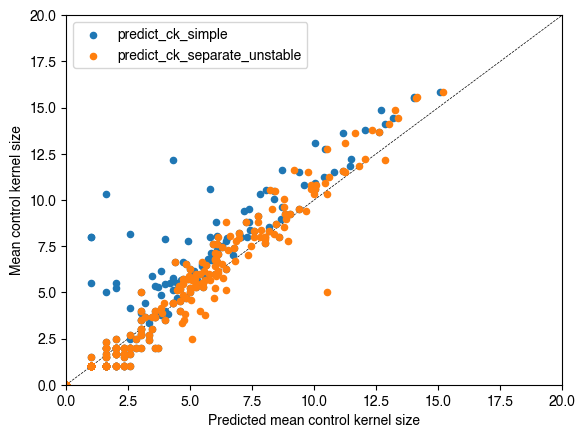

In [165]:
# plot predicted versus actual mean control kernel size: random networks

# (2024/1/11 TO DO: REMAKE THIS PLOT ONCE WE HAVE FIXED BASIN DATA FOR RANDOM NETWORKS)

for ck_func in [predict_ck_simple,predict_ck_separate_unstable]:
    #functions_to_test[:-1]: 
    #[predict_ck_simple,predict_ck_skew]
    plt.scatter(dfExactRandomAll[ck_func.__name__],
                dfExactRandomAll['mean control kernel size'],
                label=ck_func.__name__,
                s=20)

plt.xlabel('Predicted mean control kernel size')
plt.ylabel('Mean control kernel size')
minsize,maxsize = 0,20
plt.plot([minsize,maxsize],[minsize,maxsize],'k--',lw=0.5,zorder=-10)
plt.axis(xmin=minsize,xmax=maxsize,ymin=minsize,ymax=maxsize)
plt.legend()
#plt.savefig('240112_actual_versus_predicted_mean_ck_size_random_networks.pdf')

In [28]:
# find outlier network
diff = dfExactRandomAll.predict_ck_separate_unstable - dfExactRandomAll['mean control kernel size']
dfExactRandomAll[diff > 5]

,network seed,size,has limit cycles,number of attractors,number of fixed point attractors,is cell collective network,mean control kernel size,std control kernel size,mean fixed point control kernel size,std fixed point control kernel size,...,std number of distinguishing nodes with inputs,distinguishing nodes time,threshold,mean degree,inhibitory probability,predict_ck_simple,predict_ck_loglinear,predict_ck_separate_unstable,predict_ck_skew,basin_skew
name,,,,,,,,,,,,,,,,,,,,,
random_49_tp0.5_seed6027,6027,15,True,3,2,False,5.0,0.0,5.0,0.0,...,0.0,0.000012,0.5,5.0,0.9,1.584963,1.500876,10.528321,1.820665,0.707107


In [33]:
dataDictRandomBasins['random_49_tp0.5_seed6027']['basin_sizes']

array([32766,     1,     1])

In [34]:
dataDictExactRandom['random_49_tp0.5_seed6027']['control_kernel_sizes']

[None, 5, 5]

In [57]:
scipy.stats.pearsonr(dfExactRandomAllFiltered['mean control kernel size'],
                     dfExactRandomAllFiltered['predict_ck_simple'])

PearsonRResult(statistic=0.9255955843543431, pvalue=4.7762411556917385e-107)

In [58]:
scipy.stats.pearsonr(dfExactRandomAllFiltered['mean control kernel size'],
                     dfExactRandomAllFiltered['predict_ck_separate_unstable'])

PearsonRResult(statistic=0.9609081665560008, pvalue=7.018093671694413e-141)

In [64]:
scipy.stats.pearsonr(dfExactRandomAllFiltered.dropna(subset='predict_ck_skew')['mean control kernel size'],
                     dfExactRandomAllFiltered.dropna(subset='predict_ck_skew')['predict_ck_skew'])

PearsonRResult(statistic=0.9026394642505713, pvalue=5.918205963841807e-73)

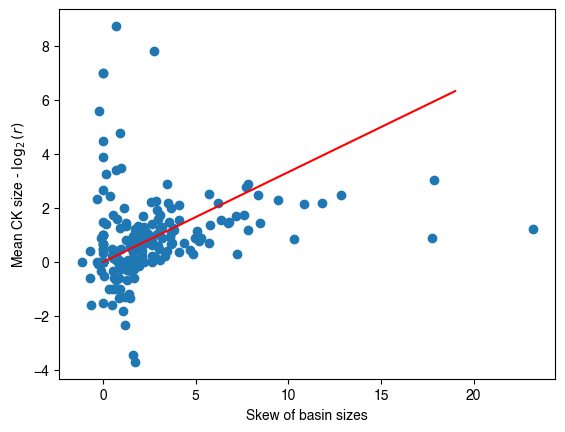

In [39]:
plt.scatter(dfExactRandomAllFiltered['basin_skew'],
            dfExactRandomAllFiltered['mean control kernel size'] - dfExactRandomAllFiltered['predict_ck_simple'])
plt.xlabel('Skew of basin sizes')
plt.ylabel('Mean CK size - $\\log_2(r)$');
plt.plot(np.arange(0,20),np.arange(0,20)/3.,color='red')

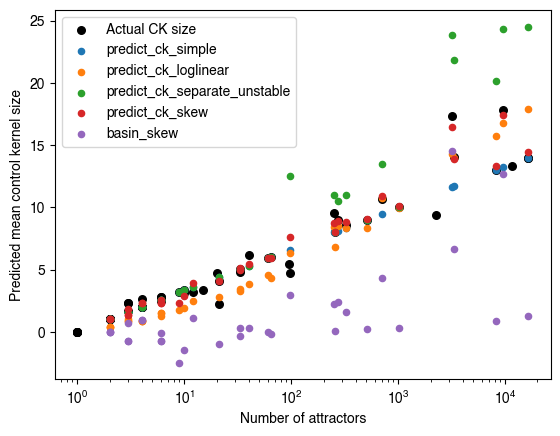

In [72]:
# plot with respect to the number of attractors

plt.scatter(ck_df['number of attractors'],
            ck_df['mean control kernel size'],
            s=30,
            label='Actual CK size',
            c='black')

for ck_func in functions_to_test:
    plt.scatter(ck_df['number of attractors'],
                ck_df[ck_func.__name__],
                label=ck_func.__name__,
                s=20)

plt.xlabel('Number of attractors')
plt.ylabel('Predicted mean control kernel size')
plt.xscale('log')
plt.legend()

#plt.plot([3185,],[15.66,],'^')

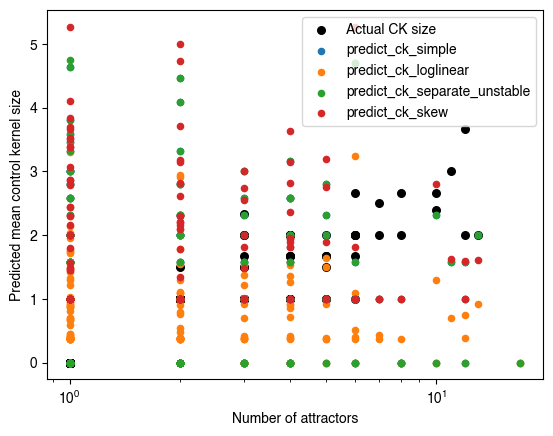

In [146]:
# plot with respect to the number of attractors: random networks

plt.scatter(dfExactRBN['number of attractors'],
            dfExactRBN['mean control kernel size'],
            s=30,
            label='Actual CK size',
            c='black')

for ck_func in functions_to_test:
    plt.scatter(dfExactRBN['number of attractors'],
                dfExactRBN[ck_func.__name__],
                label=ck_func.__name__,
                s=20)

plt.xlabel('Number of attractors')
plt.ylabel('Predicted mean control kernel size')
plt.xscale('log')
plt.legend()

# 2024/1/11 Look at attractors with small basins

In [116]:
from neet.boolean import LogicNetwork
import os
def load_cell_collective_network(directory):
    """
    Creates neet network from cell collective data in the
    given directory.
    """
    expressions_file = '{}/expressions.txt'.format(directory)
    external_file = '{}/external.txt'.format(directory)
    net = LogicNetwork.read_logic(expressions_file, external_file)
    return net

In [117]:
CELL_COLLECTIVE_DIR = '/Users/bdaniel6/ASUDropbox/Research/control-continuous/Data/Cell Collective/'
selected_network = 'HCC1954_Breast_Cell_Line_Long-term_ErbB_Network'
net = load_cell_collective_network(CELL_COLLECTIVE_DIR+selected_network)

In [122]:
# find all basins of size 1
import preimages
import importlib
importlib.reload(preimages)
import tqdm

In [120]:
def isolated_list(net,attractors,basin_samples=None):
    """
    Returns a list of Boolean values of length number of attractors
    corresponding to whether each attractor is "isolated"
    (has basin of size 1).
    
    basin_samples (None)        : Optionally give list of basin samples to avoid computing
                                  preimages of attractors that we already know are not isolated.
    """
    if basin_samples is None:
        basin_samples = np.zeros(len(attractors))
    assert(len(attractors)==len(basin_samples))
    
    is_isolated_list = []
    for i,att in enumerate(tqdm.tqdm(attractors)):
        if len(att) > 1 or basin_samples[i] > 1:
            is_isolated_list.append(False)
        else:
            decoded_att = net.decode(att[0])
            is_isolated_list.append(len(preimages.preimages(net,decoded_att))==1)
    return is_isolated_list

In [123]:
isolated_list(net,
              basinDataDict[selected_network]['attractors'],
              basinDataDict[selected_network]['sampled_basin_freqs'])

100%|███████████████████████████████████████| 9452/9452 [05:40<00:00, 27.78it/s]


[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 

In [124]:
isolated_atts = _123

In [130]:
decoded_isolated_atts = []
decoded_nonisolated_atts = []
for att_index,is_isolated in enumerate(isolated_atts):
    att = basinDataDict[selected_network]['attractors'][att_index]
    if is_isolated:
        decoded_isolated_atts.append([ net.decode(state) for state in att ])
    else:
        decoded_nonisolated_atts.append([ net.decode(state) for state in att ])

(array([0.00287584, 0.07315407, 0.19196204, 0.08241067, 0.00674024]),
 array([ 1. ,  3.8,  6.6,  9.4, 12.2, 15. ]),
 <BarContainer object of 5 artists>)

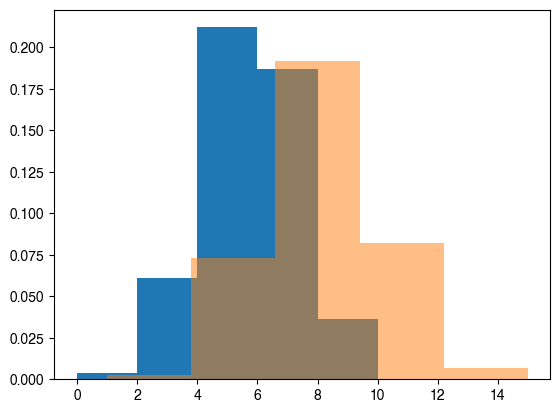

In [145]:
plt.hist(np.sum(decoded_isolated_atts,axis=2),density=True,bins=5)
plt.hist(np.sum(decoded_nonisolated_atts,axis=2),density=True,alpha=0.5,bins=5)

In [132]:
np.mean(decoded_nonisolated_atts)

0.32569703069954703

In [115]:
basinDataDict['HCC1954_Breast_Cell_Line_Long-term_ErbB_Network']

{'name': 'HCC1954_Breast_Cell_Line_Long-term_ErbB_Network',
 'network_size': 25,
 'num_states': 33554432,
 'attractors': array([[       0],
        [   16384],
        [       8],
        ...,
        [32593938],
        [32577562],
        [32593946]]),
 'num_attractors': 9452,
 'num_samples': 10000,
 'sampled_basin_freqs': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  69,
  77,
  79,
  77,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,


# 2024/1/12 histogram of CK sizes for isolated fixed points

In [187]:
# (code modified from cell-collective-find-isolated-attractors.ipynb)
relative_ck_sizes_isolated = []
relative_ck_sizes_nonisolated = []
for dataDict,basinSizesDict in zip([dataDictExactRBN, ],#dataDictExactRBN],
                                   [basinSizesExactRBN,]): #basinSizesExactRBN]):
    for name in basinSizesDict:
        if 'control_kernel_sizes' in dataDict[name]:
            ck_sizes = dataDict[name]['control_kernel_sizes']
            net_size = dataDict[name]['size']
            isolated = [ basin_size==1 for basin_size in basinSizesDict[name] ]
            relative_ck_sizes_isolated.extend([ ck_sizes[i]/net_size for i in range(len(ck_sizes)) if isolated[i] ])
            relative_ck_sizes_nonisolated.extend(
                [ ck_sizes[i]/net_size for i in range(len(ck_sizes)) \
                  if (not isolated[i]) and (ck_sizes[i] is not None) ])
        else:
            print("No control kernel data for network {}.".format(name))

In [194]:
dataDictExactRandom['random_50_tpNone_seed6150']['threshold parameter']

In [240]:
# (code modified from cell-collective-find-isolated-attractors.ipynb)
relative_ck_sizes_isolated = []
relative_ck_sizes_nonisolated = []
threshold_param = None # 0.5
net_size_filter = [10,15,20,]
min_frac_fixed_point_filter = 0.3 #0.3
for dataDict,basinSizesDict in zip([dataDictExactRandom, ],#dataDictExactRBN],
                                   [basinSizesExactRandom,]): #basinSizesExactRBN]):
    for name in basinSizesDict:
        if 'control_kernel_sizes' in dataDict[name] \
            and dataDict[name]['threshold parameter']==threshold_param\
            and dataDict[name]['size'] in net_size_filter:
            ck_sizes = dataDict[name]['control_kernel_sizes']
            net_size = dataDict[name]['size']
            isolated = [ basin_size==1 for basin_size in basinSizesDict[name] ]
            if np.mean(isolated) > min_frac_fixed_point_filter:
                relative_ck_sizes_isolated.extend(
                    [ ck_sizes[i]/net_size for i in range(len(ck_sizes)) if isolated[i] ])
                relative_ck_sizes_nonisolated.extend(
                    [ ck_sizes[i]/net_size for i in range(len(ck_sizes)) \
                      if (not isolated[i]) and (ck_sizes[i] is not None) ])
        else:
            pass
            #print("No control kernel data for network {}.".format(name))

In [204]:
len(relative_ck_sizes_isolated)

56

In [205]:
len(relative_ck_sizes_nonisolated)

14281

/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


Text(0, 0.5, 'Normalized count')

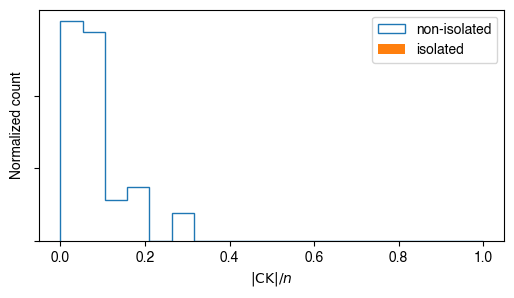

In [188]:
# just RBN networks
plt.figure(figsize=(6,3))

bins = np.linspace(0,1,20)
plt.hist(relative_ck_sizes_nonisolated,density=True,bins=bins,histtype='step',label='non-isolated')
plt.hist(relative_ck_sizes_isolated,density=True,bins=bins,label='isolated')
plt.legend()
plt.yticks([0,2.5,5],[])
plt.xlabel('$|\mathrm{CK}|/n$')
plt.ylabel('Normalized count')

Text(0, 0.5, 'Normalized count')

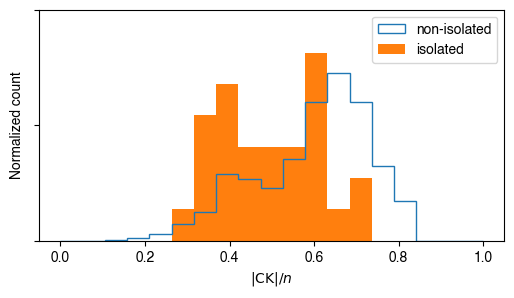

In [203]:
# threshold = 0.5
plt.figure(figsize=(6,3))

bins = np.linspace(0,1,20)
plt.hist(relative_ck_sizes_nonisolated,density=True,bins=bins,histtype='step',label='non-isolated')
plt.hist(relative_ck_sizes_isolated,density=True,bins=bins,label='isolated')
plt.legend()
plt.yticks([0,2.5,5],[])
plt.xlabel('$|\mathrm{CK}|/n$')
plt.ylabel('Normalized count')

In [225]:
relative_ck_sizes_isolated

[1.0, 0.1]

Text(0, 0.5, 'Count')

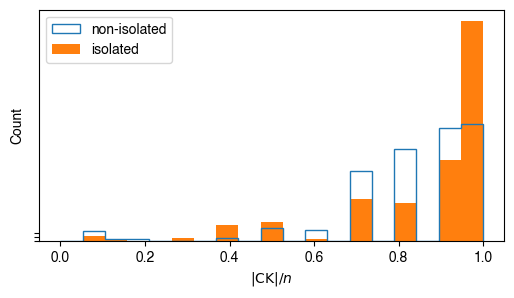

In [242]:
# zero threshold and s > 0.3
plt.figure(figsize=(6,3))

bins = np.linspace(0,1,20)
plt.hist(relative_ck_sizes_nonisolated,density=False,bins=bins,histtype='step',label='non-isolated')
plt.hist(relative_ck_sizes_isolated,density=False,bins=bins,label='isolated')
plt.legend()
plt.yticks([0,2.5,5],[])
plt.xlabel('$|\mathrm{CK}|/n$')
plt.ylabel('Count')

Text(0, 0.5, 'Normalized count')

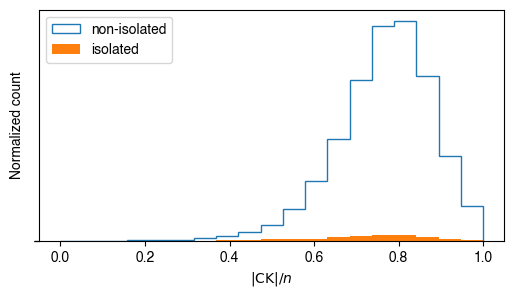

In [236]:
# zero threshold and size = 20
plt.figure(figsize=(6,3))

bins = np.linspace(0,1,20)
plt.hist(relative_ck_sizes_nonisolated,density=False,bins=bins,histtype='step',label='non-isolated')
plt.hist(relative_ck_sizes_isolated,density=False,bins=bins,label='isolated')
plt.legend()
plt.yticks([0,2.5,5],[])
plt.xlabel('$|\mathrm{CK}|/n$')
plt.ylabel('Normalized count')

Text(0, 0.5, 'Normalized count')

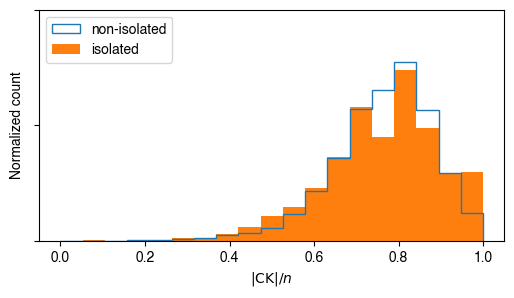

In [231]:
# zero threshold 
plt.figure(figsize=(6,3))

bins = np.linspace(0,1,20)
plt.hist(relative_ck_sizes_nonisolated,density=True,bins=bins,histtype='step',label='non-isolated')
plt.hist(relative_ck_sizes_isolated,density=True,bins=bins,label='isolated')
plt.legend()
plt.yticks([0,2.5,5],[])
plt.xlabel('$|\mathrm{CK}|/n$')
plt.ylabel('Normalized count')

Text(0, 0.5, 'Normalized count')

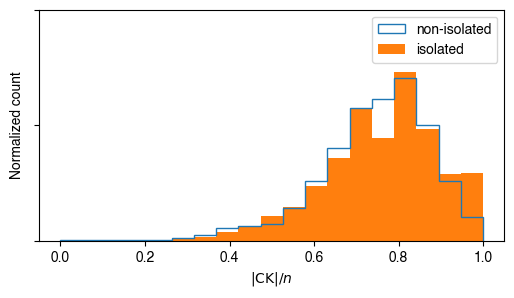

In [180]:
# all combined 
plt.figure(figsize=(6,3))

bins = np.linspace(0,1,20)
plt.hist(relative_ck_sizes_nonisolated,density=True,bins=bins,histtype='step',label='non-isolated')
plt.hist(relative_ck_sizes_isolated,density=True,bins=bins,label='isolated')
plt.legend()
plt.yticks([0,2.5,5],[])
plt.xlabel('$|\mathrm{CK}|/n$')
plt.ylabel('Normalized count')

# 2024/1/12

Text(0, 0.5, 'Difference from $\\log_2 r$')

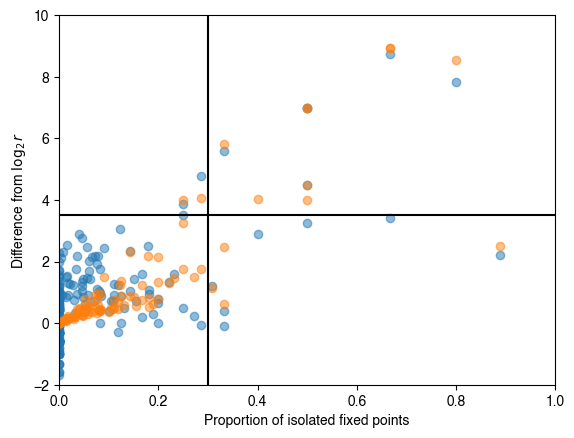

In [237]:
plt.scatter(dfExactRandomAll['proportion_of_isolated_fixed_points'],
            dfExactRandomAll['mean control kernel size'] - dfExactRandomAll['predict_ck_simple'],
            alpha=0.5)
plt.scatter(dfExactRandomAll['proportion_of_isolated_fixed_points'],
            dfExactRandomAll['predict_ck_separate_unstable'] - dfExactRandomAll['predict_ck_simple'],
            alpha=0.5)
plt.plot([0,1],[3.5,3.5],'k-')
plt.plot([0.3,0.3],[-2,10],'k-')
plt.axis(xmin=0,xmax=1.,ymin=-2,ymax=10)
plt.xlabel('Proportion of isolated fixed points')
plt.ylabel('Difference from $\log_2 r$')

In [247]:
dfExactRandomAll[dfExactRandomAll['proportion_of_isolated_fixed_points'] > 0.2][['size','number of attractors','proportion_of_isolated_fixed_points','mean control kernel size']]

,size,number of attractors,proportion_of_isolated_fixed_points,mean control kernel size
name,,,,
random_23_tp0.5_seed2829,10,8,0.250000,3.500000
random_11_tp0.5_seed1353,10,22,0.272727,4.700000
random_20_tpNone_seed2460,10,2,0.500000,5.500000
random_16_tpNone_seed1968,10,4,0.500000,5.250000
random_30_tpNone_seed3690,15,20,0.800000,12.150000
random_35_tpNone_seed4305,15,2,0.500000,8.000000
random_70_tpNone_seed8610,20,6,0.333333,8.166667
random_13_tp0.5_seed1599,10,6,0.333333,2.500000
random_46_tpNone_seed5658,15,4,0.250000,5.500000
